## Cowc dataset, data preprocessing and training on Google CLoud
In this notebook we are going to download the counting data from the [COWC](https://gdo152.llnl.gov/cowc/) dataset. This dataset is used to train a CNN for counting the number of cars in an image. training data images are 256*256 pixels and contains 0-64 cars.
The original dataset is quite messy, and I was not able to find proper informations about the labeling.

In [3]:
#reload libraries if they change and make proper plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
!nvidia-smi

Mon May 18 08:19:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
#import data
dataset = "Potsdam_ISPRS"
data_path = Path("../storage/data/")/dataset
transformed_data_folder = "all_data_transformed"

In [6]:
data_path.ls()


[PosixPath('../storage/data/Potsdam_ISPRS/test'),
 PosixPath('../storage/data/Potsdam_ISPRS/all_data_transformed'),
 PosixPath('../storage/data/Potsdam_ISPRS/.ipynb_checkpoints'),
 PosixPath('../storage/data/Potsdam_ISPRS/all_data'),
 PosixPath('../storage/data/Potsdam_ISPRS/train'),
 PosixPath('../storage/data/Potsdam_ISPRS/export_1.pkl'),
 PosixPath('../storage/data/Potsdam_ISPRS/export.pkl'),
 PosixPath('../storage/data/Potsdam_ISPRS/models')]

In [7]:
path_train_img = Path("../storage/data/" +dataset +"/train")
path_train_anno = Path("../storage/labels/COWC_train_list_64_class.txt")

path_test_img = Path("../storage/data/" +dataset +"/test")
path_test_anno = Path("../storage/labels/COWC_test_list_64_class.txt")

In [8]:
fnames_train = get_image_files(path_train_img)
fnames_test = get_image_files(path_test_img)
filenames_train = pd.DataFrame(fnames_train, columns = ["path"])
filenames_train["type"] = False
filenames_test = pd.DataFrame(fnames_test, columns = ["path"])
filenames_test["type"] = True
filenames = filenames_train.append(filenames_test)
filenames.describe()

,path,type
count,12800,12800
unique,12800,2
top,../storage/data/Potsdam_ISPRS/train/00.01534.0...,False
freq,1,10722


In [9]:
filenames.head()["path"][0]

PosixPath('../storage/data/Potsdam_ISPRS/train/00.01382.00707.000.png')

In [10]:
#parse image paths from their name
def parse_path(path):
    #return false_path[23:38]
    p = re.compile('([0-9]+.[0-9]+.[0-9]+.[0-9]+).png')
    m = p.search(str(path))
    return m.group(1)

In [11]:
filenames['img_id'] = filenames.apply (lambda row: parse_path(row["path"]), axis=1)
filenames.head()

,path,type,img_id
0,../storage/data/Potsdam_ISPRS/train/00.01382.0...,False,00.01382.00707.000
1,../storage/data/Potsdam_ISPRS/train/00.01747.0...,False,00.01747.00898.090
2,../storage/data/Potsdam_ISPRS/train/00.02163.0...,False,00.02163.00620.165
3,../storage/data/Potsdam_ISPRS/train/08.01600.0...,False,08.01600.00507.135
4,../storage/data/Potsdam_ISPRS/train/00.00251.0...,False,00.00251.00974.165


In [12]:
annotations_train = pd.read_csv(path_train_anno, header= None, sep = " ", index_col = None, names = ["img_false_path","count"])
annotations_train = annotations_train[annotations_train['img_false_path'].str.contains(dataset)]
annotations_train['img_id'] = annotations_train.apply (lambda row: parse_path(row["img_false_path"]), axis=1)

annotations_test = pd.read_csv(path_test_anno, header= None, sep = " ", index_col = None, names = ["img_false_path","count"])
annotations_test = annotations_test[annotations_test['img_false_path'].str.contains(dataset)]
annotations_test['img_id'] = annotations_test.apply (lambda row: parse_path(row["img_false_path"]), axis=1)

annotations = annotations_train.append(annotations_test)
annotations.describe()

,count
count,12800.000000
mean,2.357500
std,2.970413
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,18.000000


In [13]:
annotations_test.describe()

,count
count,2078.000000
mean,2.119346
std,2.950433
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,16.000000


In [14]:
annotations_train.describe()

,count
count,10722.000000
mean,2.403656
std,2.972199
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,18.000000


In [15]:
annotations_train.head()

,img_false_path,count,img_id
7595,Potsdam_ISPRS/train/00.00015.00996.030.png,0,00.00015.00996.030
7596,Potsdam_ISPRS/train/00.00015.01306.045.png,0,00.00015.01306.045
7597,Potsdam_ISPRS/train/00.00015.01602.165.png,0,00.00015.01602.165
7598,Potsdam_ISPRS/train/00.00016.01711.165.png,0,00.00016.01711.165
7599,Potsdam_ISPRS/train/00.00023.00703.120.png,0,00.00023.00703.120


In [16]:
annotations = pd.merge(annotations, filenames)
annotations.head()

,img_false_path,count,img_id,path,type
0,Potsdam_ISPRS/train/00.00015.00996.030.png,0,00.00015.00996.030,../storage/data/Potsdam_ISPRS/train/00.00015.0...,False
1,Potsdam_ISPRS/train/00.00015.01306.045.png,0,00.00015.01306.045,../storage/data/Potsdam_ISPRS/train/00.00015.0...,False
2,Potsdam_ISPRS/train/00.00015.01602.165.png,0,00.00015.01602.165,../storage/data/Potsdam_ISPRS/train/00.00015.0...,False
3,Potsdam_ISPRS/train/00.00016.01711.165.png,0,00.00016.01711.165,../storage/data/Potsdam_ISPRS/train/00.00016.0...,False
4,Potsdam_ISPRS/train/00.00023.00703.120.png,0,00.00023.00703.120,../storage/data/Potsdam_ISPRS/train/00.00023.0...,False


In [17]:
annotations.describe()

,count
count,12800.000000
mean,2.357500
std,2.970413
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,18.000000


In [18]:
annotations[annotations.duplicated(subset="img_id")]

,img_false_path,count,img_id,path,type


In [19]:
#remove duplicates
annotations = annotations.drop_duplicates(subset = "img_id")

In [20]:
np.random.seed(42)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
bs=256
data = (ImageList.from_df(df = annotations,  path = data_path, folder=transformed_data_folder, cols = ['img_id'], suffix='.png')
        #Where to find the data? -> in planet 'train' folder
        .split_from_df(col="type")
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(cols = ["count"])
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(planet_tfms, size=256)
        #Data augmentation? -> use tfms with a size of 128
        .databunch(bs=bs)
        .normalize(imagenet_stats))                          
        #Finally -> use the defaults for conversion to databunch

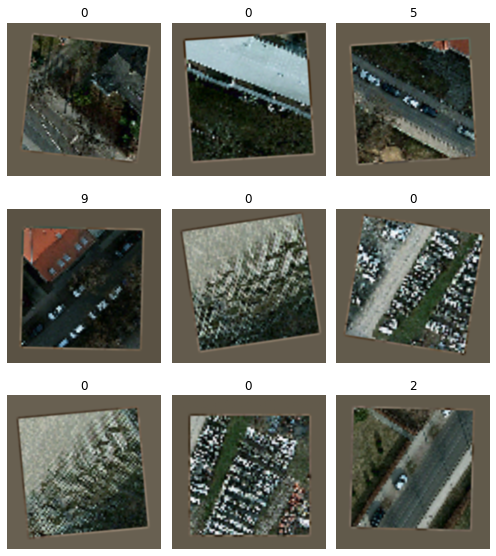

In [21]:
data.show_batch(rows=3, figsize=(7,8))

In [22]:
learn = cnn_learner(data, models.resnet34)
#learn.to_fp16() #mixed precision training (faster and less memory intensive)


epoch,train_loss,valid_loss,time
0,4.561046,#na#,00:48
1,3.396020,#na#,00:44


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


AssertionError: 

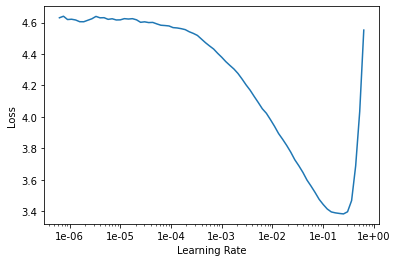

In [21]:
learn.lr_find()
learn.recorder.plot()
assert False

In [22]:

lr = 0.01
learn.fit_one_cycle(4,slice(lr))

epoch,train_loss,valid_loss,time
0,2.802473,1.704645,00:51
1,1.965607,1.349269,00:52
2,1.607890,1.182122,00:53
3,1.410302,1.157248,00:52


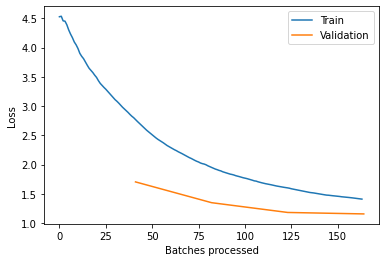

In [23]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,time
0,1.226553,#na#,01:06
1,1.807982,#na#,01:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


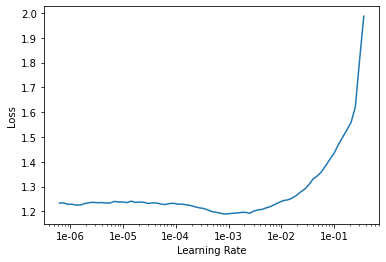

In [24]:
#train all model again, default trains only last layers
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,1.206215,1.112865,01:11
1,1.136438,1.005710,01:11
2,1.019996,1.015507,01:11
3,0.916904,0.987376,01:11
4,0.820067,0.892816,01:11
5,0.729639,0.919592,01:11
6,0.665912,0.918495,01:11
7,0.610776,0.941387,01:11
8,0.571067,0.921674,01:11
9,0.543112,0.925514,01:11


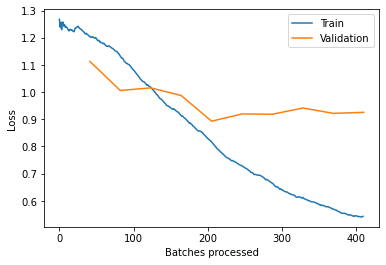

In [25]:
lr = 0.001
learn.fit_one_cycle(10,slice(lr))
learn.recorder.plot_losses()

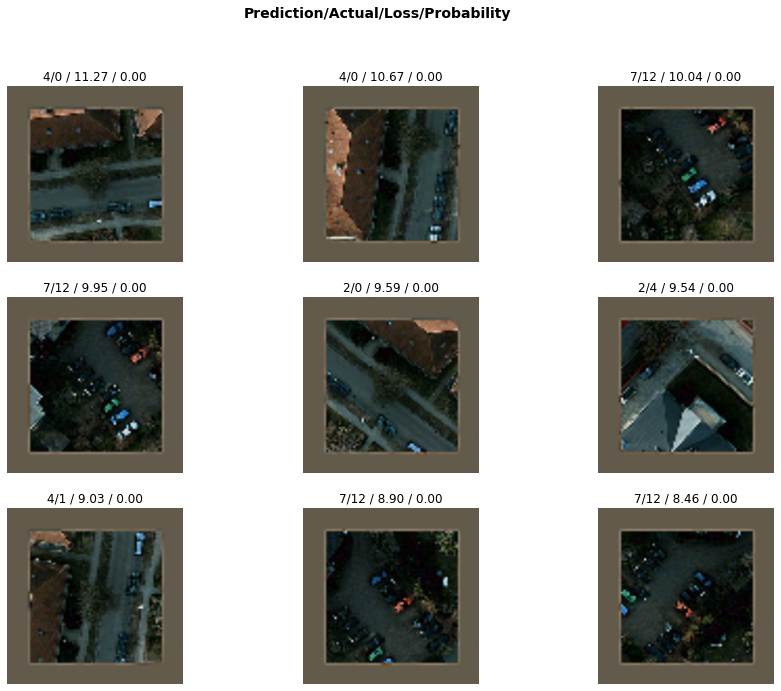

In [26]:
#check errors
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

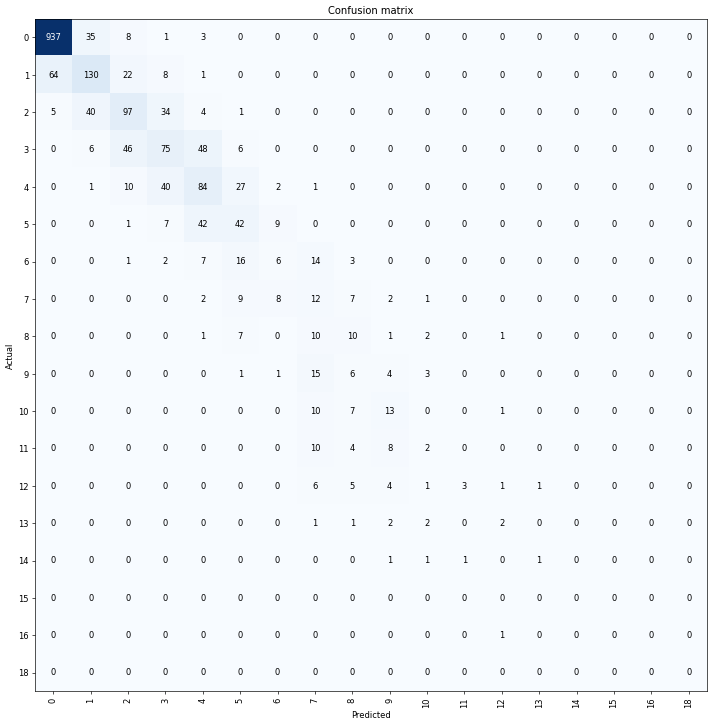

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [28]:
interp.most_confused(min_val=2)

[(1, 0, 64),
 (3, 4, 48),
 (3, 2, 46),
 (5, 4, 42),
 (2, 1, 40),
 (4, 3, 40),
 (0, 1, 35),
 (2, 3, 34),
 (4, 5, 27),
 (1, 2, 22),
 (6, 5, 16),
 (9, 7, 15),
 (6, 7, 14),
 (10, 9, 13),
 (4, 2, 10),
 (8, 7, 10),
 (10, 7, 10),
 (11, 7, 10),
 (5, 6, 9),
 (7, 5, 9),
 (0, 2, 8),
 (1, 3, 8),
 (7, 6, 8),
 (11, 9, 8),
 (5, 3, 7),
 (6, 4, 7),
 (7, 8, 7),
 (8, 5, 7),
 (10, 8, 7),
 (3, 1, 6),
 (3, 5, 6),
 (9, 8, 6),
 (12, 7, 6),
 (2, 0, 5),
 (12, 8, 5),
 (2, 4, 4),
 (11, 8, 4),
 (12, 9, 4),
 (0, 4, 3),
 (6, 8, 3),
 (9, 10, 3),
 (12, 11, 3),
 (4, 6, 2),
 (6, 3, 2),
 (7, 4, 2),
 (7, 9, 2),
 (8, 10, 2),
 (11, 10, 2),
 (13, 9, 2),
 (13, 10, 2),
 (13, 12, 2)]

In [ ]:
learn.export()

In [23]:
path = learn.path
learn2 = load_learner(path, test=ImageList.from_folder(path_test_img))
preds = learn2.get_preds(ds_type=DatasetType.Test)

In [48]:
preds[0].shape

torch.Size([2078, 18])

In [ ]:
fastai.utils.show_install()

In [ ]:
np.random.seed(2)
learn.show_results()

In [36]:
ClassificationInterpretation(learn2,preds = preds[1],ds_type = "Test")

TypeError: __init__() missing 2 required positional arguments: 'y_true' and 'losses'

In [34]:
doc(ClassificationInterpretation)

class ClassificationInterpretation [source] [test] ClassificationInterpretation ( learn : Learner , preds : Tensor , y_true : Tensor , losses : Tensor , ds_type : DatasetType = <DatasetType.Valid: 2> ) :: Interpretation 
 
 × Tests found for ClassificationInterpretation : pytest -sv tests/test_vision_train.py::test_ClassificationInterpretation [source] To run tests please refer to this guide . Interpretation methods for classification models. 
 Show in docs

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

['TTA',
 '__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_test_writeable_path',
 'add_time',
 'apply_dropout',
 'backward',
 'bn_wd',
 'callback_fns',
 'callbacks',
 'clip_grad',
 'create_opt',
 'data',
 'destroy',
 'dl',
 'export',
 'fit',
 'fit_fc',
 'fit_one_cycle',
 'freeze',
 'freeze_to',
 'get_preds',
 'init',
 'interpret',
 'layer_groups',
 'load',
 'loss_func',
 'lr_find',
 'lr_range',
 'metrics',
 'mixup',
 'model',
 'model_dir',
 'opt',
 'opt_func',
 'path',
 'pred_batch',
 'predict',
 'predict_with_mc_dropout',
 'purge',
 'recorder',
 'save',
 'show_results',
 'silent',
 